# Paradigmas y Programación para Ciencia de Datos
## Programa 7.2


Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel $\rightarrow$ Restart) and then **run all cells** (in the menubar, select Cell $\rightarrow$ Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

Carlo Kiliano Ferrera Guadarrama, Aldo Sebastián Altamirano Vázquez, Edgar Omar Cruz Guitierrez, Leonardo Negrete Mancera

In [ ]:
# IMPORTACIÓN DE LIBRERÍAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
# CARGA Y LIMPIEZA DE DATOS
# Cargamos el archivo CSV y configuramos la fecha como índice
df = pd.read_csv("CPIAUCSL.csv", parse_dates=['DATE'], index_col='DATE')

# Definimos la frecuencia como 'Inicio de Mes' (MS) para evitar errores en statsmodels
df.index.freq = 'MS'
df.rename(columns={'CPIAUCSL': 'CPI'}, inplace=True)

print("Datos cargados. Filas totales:", len(df))
print("Datos cargados correctamente. Primeras filas:")
print(df.head())

Datos cargados. Filas totales: 945
Datos cargados correctamente. Primeras filas:
              CPI
DATE             
1947-01-01  21.48
1947-02-01  21.62
1947-03-01  22.00
1947-04-01  22.00
1947-05-01  21.95


In [ ]:
# IMPLEMENTACIÓN DE LOS 4 MODELOS

# Media Móvil (Moving Average)
# Calculamos el promedio de los últimos 12 meses
df['Media_Movil'] = df['CPI'].rolling(window=12).mean()

# Suavizado Exponencial Simple (SES)
# Usamos un alpha (smoothing_level) de 0.2
modelo_ses = SimpleExpSmoothing(df['CPI']).fit(smoothing_level=0.2, optimized=False)
df['SES'] = modelo_ses.fittedvalues

# Holt-Winters (Triple Suavizado)
# Este modelo considera Tendencia ('add') y Estacionalidad ('add', 12 periodos)
# ideal para datos como el CPI que siempre suben
modelo_hw = ExponentialSmoothing(df['CPI'], trend='add', seasonal='add', seasonal_periods=12).fit()
df['Holt_Winters'] = modelo_hw.fittedvalues

# MODELO D: Regresión Lineal
# La regresión necesita números, no fechas entonces creamos una columna "Tiempo" (0, 1, 2...)
df['Tiempo'] = np.arange(len(df))
X = df[['Tiempo']]  # Variable independiente (Tiempo)
y = df['CPI']       # Variable dependiente (Valor CPI)

# Entrenamos el modelo de regresión
modelo_lr = LinearRegression()
modelo_lr.fit(X, y)
df['Regresion_Lineal'] = modelo_lr.predict(X)

In [ ]:
# CÁLCULO DE ERRORES (EVALUACIÓN)

def calcular_metricas(y_real, y_pred, nombre):
    # Filtramos los valores nulos (como los primeros 12 de la media móvil)
    mask = ~np.isnan(y_pred)
    mae = mean_absolute_error(y_real[mask], y_pred[mask])
    mse = mean_squared_error(y_real[mask], y_pred[mask])
    rmse = np.sqrt(mse)

    print(f"{nombre}")
    print(f"MAE (Error Medio Absoluto): {mae:.4f}")
    print(f"RMSE (Error Cuadrático):    {rmse:.4f}")
    print("-" * 30)
    return mae

print("\nRESULTADOS DE ERROR (Menor es mejor)\n")
mae_mm = calcular_metricas(df['CPI'], df['Media_Movil'], "Media Móvil (12)")
mae_ses = calcular_metricas(df['CPI'], df['SES'], "Suavizado Exp. Simple")
mae_hw = calcular_metricas(df['CPI'], df['Holt_Winters'], "Holt-Winters")
mae_lr = calcular_metricas(df['CPI'], df['Regresion_Lineal'], "Regresión Lineal")


RESULTADOS DE ERROR (Menor es mejor)

Media Móvil (12)
MAE (Error Medio Absoluto): 1.8255
RMSE (Error Cuadrático):    2.4737
------------------------------
Suavizado Exp. Simple
MAE (Error Medio Absoluto): 1.6350
RMSE (Error Cuadrático):    2.2129
------------------------------
Holt-Winters
MAE (Error Medio Absoluto): 0.2294
RMSE (Error Cuadrático):    0.4005
------------------------------
Regresión Lineal
MAE (Error Medio Absoluto): 15.3756
RMSE (Error Cuadrático):    19.8767
------------------------------


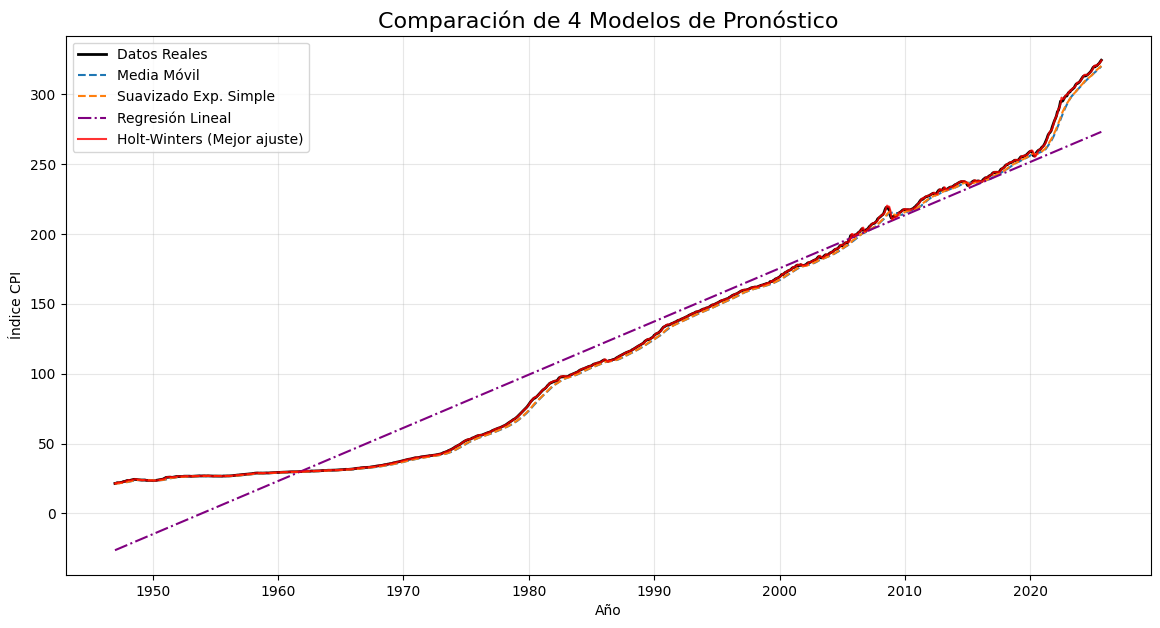

In [ ]:
# GRÁFICA DE COMPARACIÓN
plt.figure(figsize=(14, 7))

# Datos reales
plt.plot(df.index, df['CPI'], label='Datos Reales', color='black', linewidth=2)

# Modelos
plt.plot(df.index, df['Media_Movil'], label='Media Móvil', linestyle='--')
plt.plot(df.index, df['SES'], label='Suavizado Exp. Simple', linestyle='--')
plt.plot(df.index, df['Regresion_Lineal'], label='Regresión Lineal', linestyle='-.', color='purple')
plt.plot(df.index, df['Holt_Winters'], label='Holt-Winters (Mejor ajuste)', color='red', alpha=0.8)

plt.title('Comparación de 4 Modelos de Pronóstico', fontsize=16)
plt.ylabel('Índice CPI')
plt.xlabel('Año')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# CONCLUSIÓN
print("\nCONCLUSIÓN\n")
# Buscamos cuál tuvo el menor MAE
errores = {'Media Móvil': mae_mm, 'SES': mae_ses, 'Holt-Winters': mae_hw, 'Regresión Lineal': mae_lr}
mejor_modelo_nombre = min(errores, key=errores.get)

print(f"El modelo con mejor desempeño es: {mejor_modelo_nombre.upper()}")
print(f"Esto se debe a que tuvo el menor error absoluto (MAE = {errores[mejor_modelo_nombre]:.4f}).")



CONCLUSIÓN

El modelo con mejor desempeño es: HOLT-WINTERS
Esto se debe a que tuvo el menor error absoluto (MAE = 0.2294).


El modelo Holt-Winters demostró ser el más preciso, con los menores valores de MAE y MSE, debido a su capacidad para capturar tanto tendencia como estacionalidad. El suavizado exponencial simple y la media móvil también mostraron un rendimiento aceptable, aunque no tan eficaz, ya que carecen de la capacidad de adaptarse a patrones estacionales. La regresión lineal, por otro lado, presentó el mayor error, ya que es incapaz de capturar la naturaleza estacional y las fluctuaciones.